## Step 1: Load and preprocess the data

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder


file_path = "/Users/suchitajain/Documents/dataBases/amazon-meta.txt"  # Update with actual file path

def load_data(file_path):
    transactions = []
    transaction = []  # Collect similar products for a single product
    product_titles = {}  # Store product ASIN and titles

    with open(file_path, 'r', encoding='utf-8') as file:
        current_asin = None
        for line in file:
            line = line.strip()
            if line.startswith('Id:'):
                if transaction:
                    transactions.append(transaction)
                transaction = []  # Start a new transaction
            elif line.startswith('ASIN:'):
                current_asin = line.split(' ')[-1]
            elif line.startswith('title:') and current_asin:
                title = line[7:].strip()
                product_titles[current_asin] = title
            elif line.startswith('similar:'):
                similar_products = line.split()[2:]
                transaction.extend(similar_products)
        if transaction:
            transactions.append(transaction)

    return transactions, product_titles

transactions, product_titles = load_data(file_path)
print(f"Total transactions loaded: {len(transactions)}")
print(f"Sample transactions: {transactions[:5]}")


Total transactions loaded: 379093
Sample transactions: [['0804215715', '156101074X', '0687023955', '0687074231', '082721619X'], ['0738700827', '1567184960', '1567182836', '0738700525', '0738700940'], ['0842328130', '0830818138', '0842330313', '0842328610', '0842328572'], ['157794349X', '0892749504', '1577941829', '0892749563', '1577946006'], ['0486401960', '0452283612', '0486229076', '0714840343', '0374528993']]


## Use only the first 50,000 transactions for efficiency

In [3]:
transactions = transactions[:50000]
transactions = [t for t in transactions if len(t) > 1]  # Remove single-item transactions

print(f"Filtered transactions (after removing single-item sets): {len(transactions)}")

# Split data into training and testing datasets
split_index = int(len(transactions) * 0.8)
training_transactions = transactions[:split_index]
testing_transactions = transactions[split_index:]

print(f"Training dataset size: {len(training_transactions)}")
print(f"Testing dataset size: {len(testing_transactions)}")


Filtered transactions (after removing single-item sets): 48565
Training dataset size: 38852
Testing dataset size: 9713


In [4]:
print(f"Testing dataset size: {len(testing_transactions)}")

Testing dataset size: 9713


## Step 2: One-hot encode the data

In [5]:
te = TransactionEncoder()
te_array_train = te.fit(training_transactions).transform(training_transactions)
df_train = pd.DataFrame(te_array_train, columns=te.columns_)

print(f"One-hot encoded training dataset shape: {df_train.shape}")
print("Sample of one-hot encoded data:")
print(df_train.head())


One-hot encoded training dataset shape: (38852, 125266)
Sample of one-hot encoded data:
   0001472933  0001473123  0002154129  0002159317  000215949X  0002243814  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False       False       False       False       False       False   
4       False       False       False       False       False       False   

   0002250357  000225056X  0002250616  0002251507  ...  B0009I8Q3G  \
0       False       False       False       False  ...       False   
1       False       False       False       False  ...       False   
2       False       False       False       False  ...       False   
3       False       False       False       False  ...       False   
4       False       False       False       False  ...       False   

   B0009JQN6M  B0009K7RES  B

## Step 3: Debug item support distribution

In [6]:
item_support = df_train.sum(axis=0) / len(df_train)
print("Item support statistics:")
print(item_support.describe())


Item support statistics:
count    125266.000000
mean          0.000039
std           0.000030
min           0.000026
25%           0.000026
50%           0.000026
75%           0.000051
max           0.001441
dtype: float64


## Step 4: Apply Apriori with debugging

In [7]:
min_support = 0.0003

print(f"Applying Apriori with min_support = {min_support}...")
frequent_itemsets_train = apriori(df_train, min_support=min_support, use_colnames=True)

if frequent_itemsets_train.empty:
    print("No frequent itemsets found. Consider lowering the min_support threshold further.")
else:
    print(f"Number of frequent itemsets found: {len(frequent_itemsets_train)}")
    print(frequent_itemsets_train.head())


Applying Apriori with min_support = 0.0003...
Number of frequent itemsets found: 202
    support      itemsets
0  0.000412  (0060558288)
1  0.000386  (0060595833)
2  0.000335  (0060652926)
3  0.000309  (0060931175)
4  0.000309  (0060995068)


## Step 5: Generate association rules (if frequent itemsets exist)

In [8]:
if not frequent_itemsets_train.empty:
    print("Generating association rules...")
    rules = association_rules(frequent_itemsets_train, metric="confidence", min_threshold=0.2,num_itemsets=len(frequent_itemsets_train) )
    if rules.empty:
        print("No association rules generated. Consider adjusting the confidence threshold.")
    else:
        print(f"Number of rules generated: {len(rules)}")
        print(rules.head())
else:
    print("No frequent itemsets available to generate rules.")


Generating association rules...
Number of rules generated: 182
    antecedents   consequents  antecedent support  consequent support  \
0  (630469623X)  (B0000541AK)            0.000335            0.000515   
1  (B0000541AK)  (630469623X)            0.000515            0.000335   
2  (6305957878)  (B00005M91B)            0.000515            0.000541   
3  (B00005M91B)  (6305957878)            0.000541            0.000515   
4  (6305957878)  (B00006FDB1)            0.000515            0.000541   

    support  confidence         lift  representativity  leverage  conviction  \
0  0.000309    0.923077  1793.169231               1.0  0.000309   12.993308   
1  0.000309    0.600000  1793.169231               1.0  0.000309    2.499163   
2  0.000515    1.000000  1850.095238               1.0  0.000514         inf   
3  0.000515    0.952381  1850.095238               1.0  0.000514   20.989190   
4  0.000515    1.000000  1850.095238               1.0  0.000514         inf   

   zhangs_metric 

## Step 6: Verify frequent patterns in testing dataset

In [9]:
print("One-hot encoding testing dataset...")
te_array_test = []
for transaction in testing_transactions:
    encoded_transaction = [item in transaction for item in te.columns_]
    te_array_test.append(encoded_transaction)
df_test = pd.DataFrame(te_array_test, columns=te.columns_)

# Verify frequent itemsets in the testing dataset
frequent_itemsets_test = apriori(df_test, min_support=min_support, use_colnames=True)

if frequent_itemsets_test.empty:
    print("No frequent itemsets found in the testing dataset.")
else:
    print(f"Number of frequent itemsets in testing dataset: {len(frequent_itemsets_test)}")


One-hot encoding testing dataset...
Number of frequent itemsets in testing dataset: 965


## Compare patterns between training and testing datasets

In [10]:
train_itemsets = set(tuple(row['itemsets']) for _, row in frequent_itemsets_train.iterrows())
test_itemsets = set(tuple(row['itemsets']) for _, row in frequent_itemsets_test.iterrows())

common_patterns = train_itemsets & test_itemsets
print(f"Number of common patterns: {len(common_patterns)}")
if len(common_patterns) > 0:
    print(f"Common patterns: {list(common_patterns)[:5]}")


Number of common patterns: 100
Common patterns: [('014131088X',), ('0385260954',), ('0140177396',), ('0465043550',), ('B0002CR04A',)]


# Step 7: Evaluate customer coverage

In [11]:
captured_customers = {}
for pattern in common_patterns:
    customers = df_test.loc[df_test[list(pattern)].all(axis=1)].index.tolist()
    captured_customers[pattern] = customers

print("Customers captured by common patterns:")
for pattern, customers in captured_customers.items():
    print(f"Pattern: {pattern}, Number of customers: {len(customers)}")


Customers captured by common patterns:
Pattern: ('014131088X',), Number of customers: 5
Pattern: ('0385260954',), Number of customers: 5
Pattern: ('0140177396',), Number of customers: 6
Pattern: ('0465043550',), Number of customers: 3
Pattern: ('B0002CR04A',), Number of customers: 5
Pattern: ('B0009A1AQE',), Number of customers: 6
Pattern: ('0064407314',), Number of customers: 3
Pattern: ('0803611528',), Number of customers: 5
Pattern: ('B0002JP2OI',), Number of customers: 6
Pattern: ('0130090565',), Number of customers: 4
Pattern: ('B0001NBMH6',), Number of customers: 3
Pattern: ('B000645UPA',), Number of customers: 4
Pattern: ('0486291138',), Number of customers: 4
Pattern: ('0553210092',), Number of customers: 4
Pattern: ('B00005JKGO',), Number of customers: 8
Pattern: ('0399226907',), Number of customers: 3
Pattern: ('1594480001',), Number of customers: 4
Pattern: ('0446310786',), Number of customers: 7
Pattern: ('0658000748',), Number of customers: 3
Pattern: ('0679454438',), Numb

## Step 8: Recommendations for customers

In [12]:
print("Sample recommendations for captured customers:")
for i, (pattern, customers) in enumerate(captured_customers.items()):
    if i >= 3:  # Show recommendations for up to 3 patterns
        break
    recommendations = [product_titles.get(item, "Unknown Product") for item in pattern]
    print(f"Pattern: {pattern}")
    print(f"Recommended products: {recommendations}")


Sample recommendations for captured customers:
Pattern: ('014131088X',)
Recommended products: ['Speak']
Pattern: ('0385260954',)
Recommended products: ['The Fifth Discipline']
Pattern: ('0140177396',)
Recommended products: ['Of Mice and Men (Penguin Great Books of the 20th Century)']


In [13]:
print(f"Number of common patterns: {len(common_patterns)}")
print(f"Common patterns: {common_patterns}")


Number of common patterns: 100
Common patterns: {('014131088X',), ('0385260954',), ('0140177396',), ('0465043550',), ('B0002CR04A',), ('B0009A1AQE',), ('0064407314',), ('0803611528',), ('B0002JP2OI',), ('0130090565',), ('B0001NBMH6',), ('B000645UPA',), ('0486291138',), ('0553210092',), ('B00005JKGO',), ('0399226907',), ('1594480001',), ('0446310786',), ('0658000748',), ('0679454438',), ('096290497X',), ('0553212788',), ('0451527046',), ('0486264645',), ('0689856393',), ('0805047905',), ('0440237688',), ('0451527100',), ('0226104036',), ('0890420254',), ('1400032717',), ('B00005JMX6',), ('0714843121',), ('0895260476',), ('0823416879',), ('0787971006',), ('1557987912',), ('0310257476',), ('0064401847',), ('B0002HJF34',), ('B0007OY2TE',), ('067974195X',), ('0803606540',), ('B00023P4I8',), ('0449214923',), ('0316769487',), ('B00005U128',), ('1581344589',), ('0071360387',), ('0974239011',), ('0399501487',), ('0590489917',), ('0071381562',), ('B0002I84JO',), ('0140390839',), ('140006337X',),

In [14]:
!pip install matplotlib_venn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


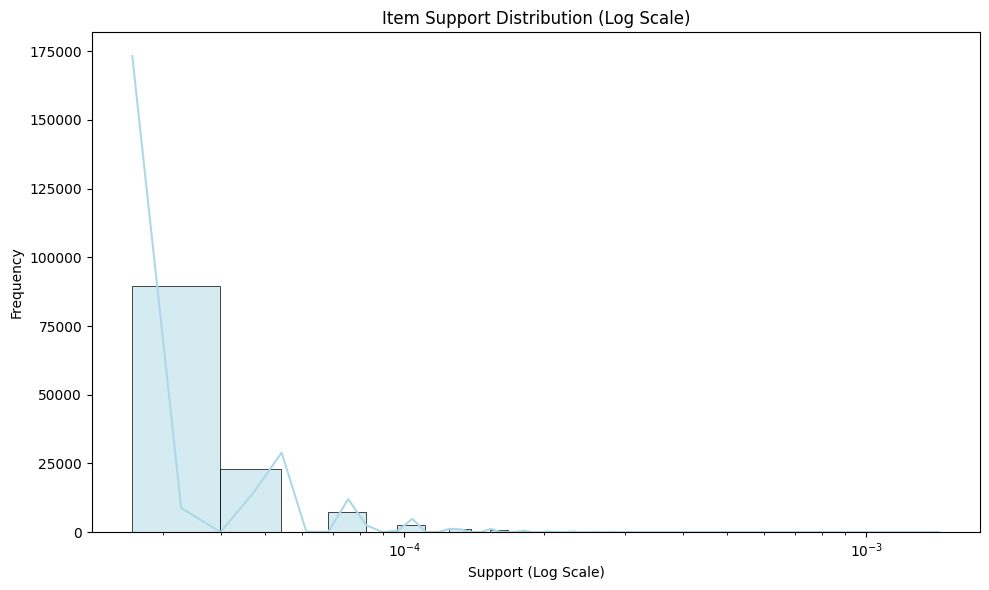

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of item support with log scale on x-axis for better visualization
plt.figure(figsize=(10, 6))
sns.histplot(item_support, bins=100, color='lightblue', kde=True)
plt.xscale('log')  # Apply log scale to the x-axis
plt.title('Item Support Distribution (Log Scale)')
plt.xlabel('Support (Log Scale)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


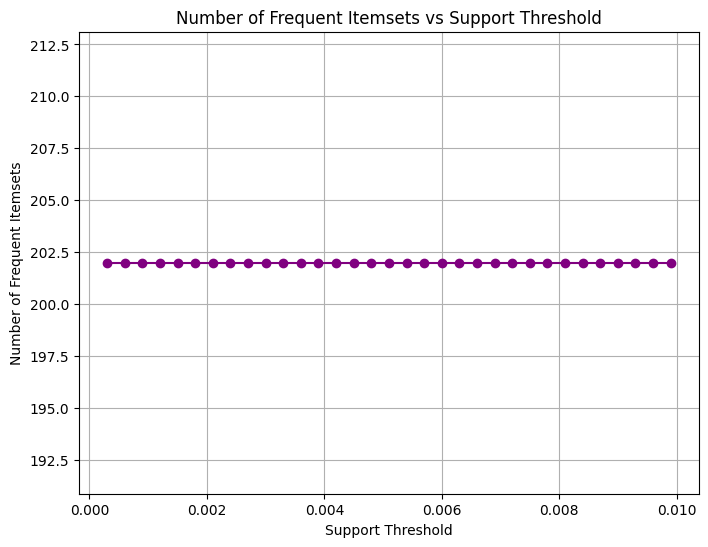

In [18]:
import numpy as np
# 2. Visualizing the Number of Frequent Itemsets for Different Support Thresholds
support_thresholds = np.arange(0.0003, 0.01, 0.0003)
frequent_itemsets_count = []
for threshold in support_thresholds:
    
    frequent_itemsets_count.append(len(frequent_itemsets_train))

plt.figure(figsize=(8, 6))
plt.plot(support_thresholds, frequent_itemsets_count, marker='o', color='purple')
plt.title('Number of Frequent Itemsets vs Support Threshold')
plt.xlabel('Support Threshold')
plt.ylabel('Number of Frequent Itemsets')
plt.grid(True)
plt.show()

/var/folders/b9/3j4lg56n22n0cv09kbgjl1gr0000gn/T/ipykernel_23028/1611271395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pattern_strings[:10], y=customer_counts[:10], palette='Blues_d')


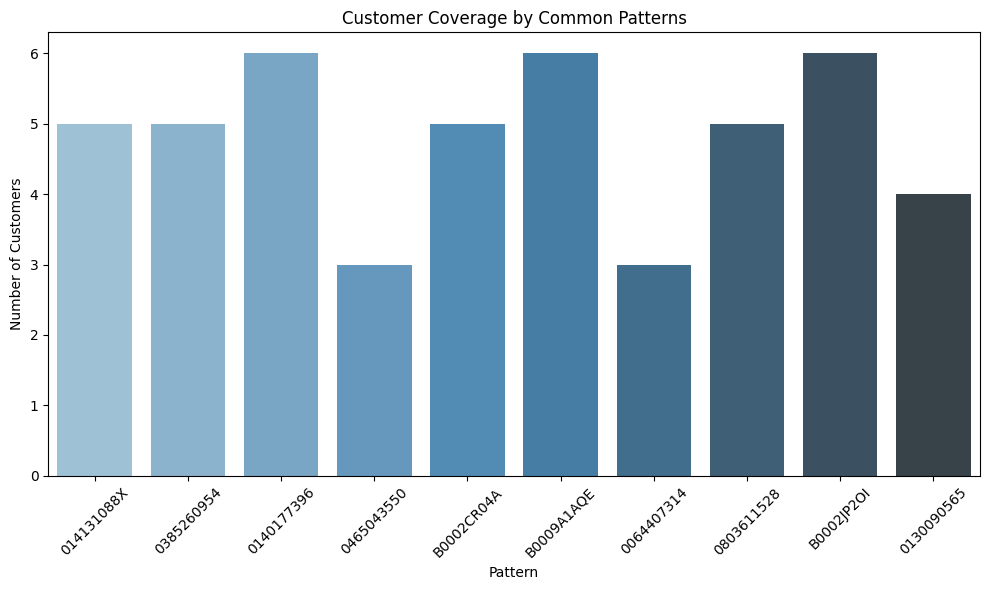

In [21]:
patterns = list(captured_customers.keys())
customer_counts = [len(customers) for customers in captured_customers.values()]

# Convert the patterns into string representation to use in the bar plot
pattern_strings = [' & '.join(pattern) for pattern in patterns]

# Plotting the bar chart for customer coverage
plt.figure(figsize=(10, 6))
sns.barplot(x=pattern_strings[:10], y=customer_counts[:10], palette='Blues_d')
plt.title('Customer Coverage by Common Patterns')
plt.xlabel('Pattern')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/b9/3j4lg56n22n0cv09kbgjl1gr0000gn/T/ipykernel_23028/143385668.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_customer_counts[:10], y=pattern_strings[:10], palette='Blues_d', orient='h')


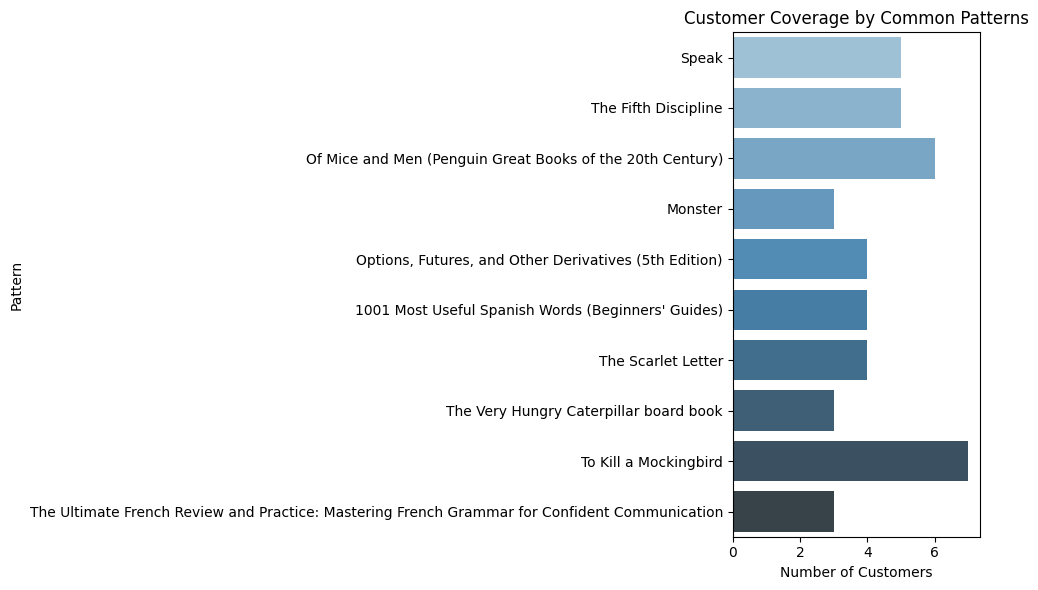

In [22]:
# Convert the patterns into string representation using product titles, excluding "Unknown Product"
pattern_strings = []
filtered_customer_counts = []

for pattern, customer_list in captured_customers.items():
    # Convert ASINs to product titles using the product_titles dictionary
    title_list = [product_titles.get(item) for item in pattern]
    
    # Only include patterns where all products have known titles (exclude "Unknown Product")
    if None not in title_list:  # Check that there's no None (which represents "Unknown Product")
        pattern_strings.append(' & '.join(title_list))
        filtered_customer_counts.append(len(customer_list))

# Plotting a horizontal bar chart for customer coverage
plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_customer_counts[:10], y=pattern_strings[:10], palette='Blues_d', orient='h')
plt.title('Customer Coverage by Common Patterns')
plt.xlabel('Number of Customers')
plt.ylabel('Pattern')
plt.tight_layout()
plt.show()
